In [25]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_train_accuracy, central_test_accuracy
from network import exponential_graph, get_alphas
from optimization import gd_reg_local_FW, local_FW
from utils import generate_fixed_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
# set graph of nodes with local personalized data
NB_ITER = 10000
D = 20
n = 200
NOISE_R = 0.05
random_state = 2017

BETA = 10

K, X, Y, X_test, Y_test, max_nb_instances, theta_true, angles, groundtruth_adj_matrix = generate_fixed_moons(D, sample_error_rate=NOISE_R, rnd_state=2017)

# set graph
nodes, adj_matrix, similarities = exponential_graph(X, Y, X_test, Y_test, K, theta_true, max_nb_instances)

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D+1, min_v=vmin, max_v=vmax)

results = {}

In [81]:
from evaluation import kalo_objective

# graph discovery
gd_pace = 2000

MU, LA = 0.1, 1

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
}

paces = [100, 200, 400, 800, 1600, 3000]
for pace in paces:
    print("Dada-Learned-$t_{\\alpha}=%s$" % (pace))
    
    results["Dada-Learned-$t_{\alpha}=%s$" % (pace)] = []
    for _ in range(3):
        gd_nodes = deepcopy(nodes)
        results["Dada-Learned-$t_{\alpha}=%s$" % (pace)].append(gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"block_kalo", "pace_gd": pace, 
                            "args":(MU, LA, 10, 1000)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=100))

Dada-Learned-$t_{\alpha}=100$
Dada-Learned-$t_{\alpha}=200$
Dada-Learned-$t_{\alpha}=400$
Dada-Learned-$t_{\alpha}=800$
Dada-Learned-$t_{\alpha}=1600$
Dada-Learned-$t_{\alpha}=3000$


../src/optimization.py:50: RuntimeWarning: divide by zero encountered in log
  return d.dot(l) + (mu / 2) * (w.dot(z) - np.log(d).sum() + la * (mu / 2) * w.dot(w))
../src/optimization.py:146: RuntimeWarning: divide by zero encountered in true_divide
  grad = l[rnd_j].dot(S_block) + (mu / 2) * (z[idx_block] - (1. / d_block).dot(S_block) + 2 * la * (mu / 2) * new_w[idx_block])
../src/optimization.py:149: RuntimeWarning: invalid value encountered in less
  new_w[new_w < 0] = 0
../src/optimization.py:47: RuntimeWarning: invalid value encountered in less
  if np.any(d < 0):


In [82]:
local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=1000, monitors={})
results["Local-Adaboost"] = {}
results["Local-Adaboost"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["Local-Adaboost"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [88]:
# average over iterations
dict_avgs = {}

for pace in paces:
    
    dict_avgs[pace] = {}
    
    k = "Dada-Learned-$t_{\alpha}=%s$" % (pace)
    train_avgs = np.asarray([[r['train-accuracy'] for r in results[k][i]] for i in range(3)])
    test_avgs = np.asarray([[r['test-accuracy'] for r in results[k][i]] for i in range(3)])
   
    dict_avgs[pace]["train"] = np.mean(train_avgs, axis=0)
    dict_avgs[pace]["test"] = np.mean(test_avgs, axis=0)


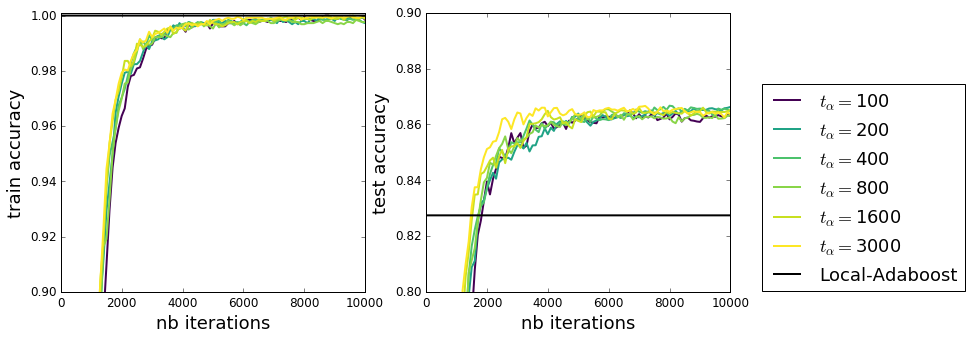

In [96]:
from math import log
plt.figure(1, figsize=(12, 5))

cmap = plt.get_cmap("viridis")

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=18)
plt.ylabel('train accuracy', fontsize=18)
plt.xlim(0, max_iter)
plt.ylim(0.9, 1.001)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for pace in paces:
    label = "$t_{\\alpha}=$" + str(pace)
    plt.plot([i*100 for i in range(len(dict_avgs[pace]["train"]))], dict_avgs[pace]["train"], label=label, color=cmap(log(pace-99)/log(2900)), linewidth=2)

plt.plot(range(NB_ITER+1), [results['Local-Adaboost']['train-accuracy']]*(NB_ITER+1), label="Local-Adaboost", color="k", linewidth=2)

# plt.legend(loc='lower right', fontsize=15)

plt.subplot(122)
plt.xlabel('nb iterations', fontsize=18)
plt.ylabel('test accuracy', fontsize=18)
plt.xlim(0, max_iter)
plt.ylim(0.8, 0.9)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for pace in paces:
    label = "$t_{\\alpha}=$" + str(pace)
    plt.plot([i*100 for i in range(len(dict_avgs[pace]["test"]))], dict_avgs[pace]["test"], label=label, color=cmap(log(pace-99)/log(2900)), linewidth=2)

plt.plot(range(NB_ITER+1), [results['Local-Adaboost']['test-accuracy']]*(NB_ITER+1), label="Local-Adaboost", color="k", linewidth=2)

plt.legend(loc='lower right', fontsize=18, bbox_to_anchor=(1.8, -0.03))

plt.savefig("moons-clust-t-alpha-2.pdf", bbox_inches="tight")